In [1]:
import numpy as np
import mrcfile
from matplotlib import pyplot as plt
%matplotlib inline
import collections
import tensorflow as tf
from tensorflow import spectral
from ClassFiles.relion_fixed_it import load_star
from ClassFiles.Denoiser import Denoiser
from ClassFiles.ut import l2
from ClassFiles.Utilities import registration
from ClassFiles.ut import locate_gt, rfft, irfft, unify_form, Rescaler, getStarFiles, getRecos

In [8]:
path = getStarFiles(noise='016', method='EM', iter='1', eval_data=False)[0]
print(path)

/local/scratch/public/sl767/MRC_Data/Data/Data_0016_10k/train/EM/3I62/3I62_mult0016_it001_half2_class001_external_reconstruct.star


In [9]:
file = load_star(path)

In [10]:
rlnExtReconsDataReal = file['external_reconstruct_general']['rlnExtReconsDataReal'][:37]
rlnExtReconsDataReal += 'Data/'
rlnExtReconsDataReal += file['external_reconstruct_general']['rlnExtReconsDataReal'][37:50]
rlnExtReconsDataReal += 'train/'
rlnExtReconsDataReal += file['external_reconstruct_general']['rlnExtReconsDataReal'][50:]
print(rlnExtReconsDataReal)

rlnExtReconsDataImag = file['external_reconstruct_general']['rlnExtReconsDataImag'][:37]
rlnExtReconsDataImag += 'Data/'
rlnExtReconsDataImag += file['external_reconstruct_general']['rlnExtReconsDataImag'][37:50]
rlnExtReconsDataImag += 'train/'
rlnExtReconsDataImag += file['external_reconstruct_general']['rlnExtReconsDataImag'][50:]
print(rlnExtReconsDataImag)

rlnExtReconsWeight = file['external_reconstruct_general']['rlnExtReconsWeight'][:37]
rlnExtReconsWeight += 'Data/'
rlnExtReconsWeight += file['external_reconstruct_general']['rlnExtReconsWeight'][37:50]
rlnExtReconsWeight += 'train/'
rlnExtReconsWeight += file['external_reconstruct_general']['rlnExtReconsWeight'][50:]
print(rlnExtReconsWeight)

rlnExtReconsResult = file['external_reconstruct_general']['rlnExtReconsResult'][:37]
rlnExtReconsResult += 'Data/'
rlnExtReconsResult += file['external_reconstruct_general']['rlnExtReconsResult'][37:50]
rlnExtReconsResult += 'train/'
rlnExtReconsResult += file['external_reconstruct_general']['rlnExtReconsResult'][50:]
print(rlnExtReconsResult)
print(locate_gt('3I62', full_path=False))

with mrcfile.open(rlnExtReconsDataReal) as mrc:
    data_real = mrc.data.copy()
with mrcfile.open(rlnExtReconsDataImag) as mrc:
    data_im = mrc.data.copy()
with mrcfile.open(rlnExtReconsWeight) as mrc:
    kernel = mrc.data.copy()
with mrcfile.open(locate_gt('3I62', full_path=False)) as mrc:
    ground_truth = mrc.data.copy()
with mrcfile.open(rlnExtReconsResult) as mrc:
    REL_recon = mrc.data.copy()

ground_truth = unify_form(ground_truth)
ground_truth /= np.sum(np.abs(ground_truth))

/local/scratch/public/sl767/MRC_Data/Data/Data_0016_10ktrain//EM/3I62/3I62_mult0016_it001_half2_class001_external_reconstruct_data_real.mrc
/local/scratch/public/sl767/MRC_Data/Data/Data_0016_10ktrain//EM/3I62/3I62_mult0016_it001_half2_class001_external_reconstruct_data_imag.mrc
/local/scratch/public/sl767/MRC_Data/Data/Data_0016_10ktrain//EM/3I62/3I62_mult0016_it001_half2_class001_external_reconstruct_weight.mrc
/local/scratch/public/sl767/MRC_Data/Data/Data_0016_10ktrain//EM/3I62/3I62_mult0016_it001_half2_class001_external_reconstruct.mrc
/local/scratch/public/sl767/MRC_Data/org/training/3/3I62.mrc


FileNotFoundError: [Errno 2] No such file or directory: '/local/scratch/public/sl767/MRC_Data/Data/Data_0016_10ktrain//EM/3I62/3I62_mult0016_it001_half2_class001_external_reconstruct_data_real.mrc'

In [5]:
complex_data = data_real + 1j * data_im

In [6]:
saves_path = '/local/scratch/public/sl767/SPA/Saves/Denoiser/All_EM_016_trained'
denoiser = Denoiser(saves_path, load=True)

INFO:tensorflow:Summary name Ground Truth is illegal; using Ground_Truth instead.
INFO:tensorflow:Summary name Ground Truth is illegal; using Ground_Truth instead.
INFO:tensorflow:Restoring parameters from /local/scratch/public/sl767/SPA/Saves/Denoiser/Final_EM_trained/Data/model-31000
Save restored


In [7]:
def vis(data, fourier=True):
    if fourier:
        data = irfft(data)
    #plt.imshow(im[...,45])
    plt.imshow(np.mean(data.squeeze(), axis=-1))

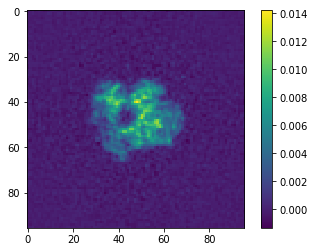

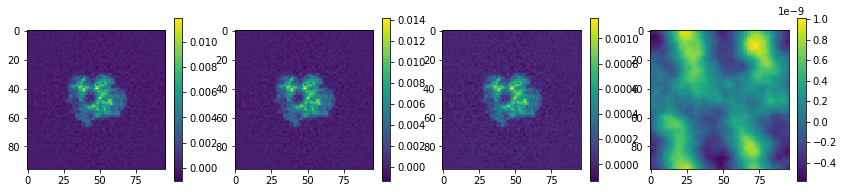

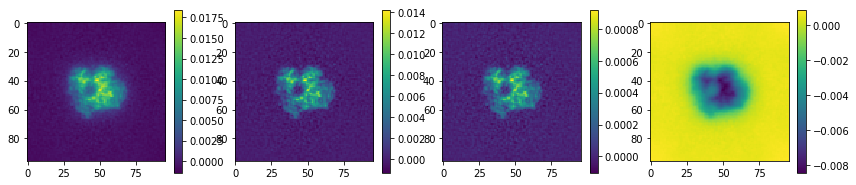

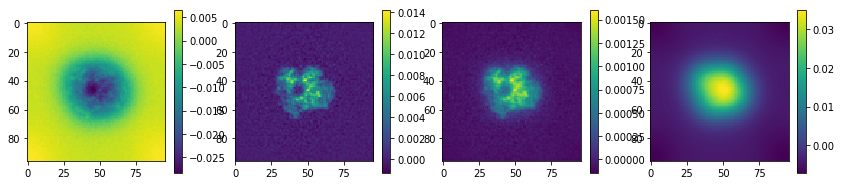

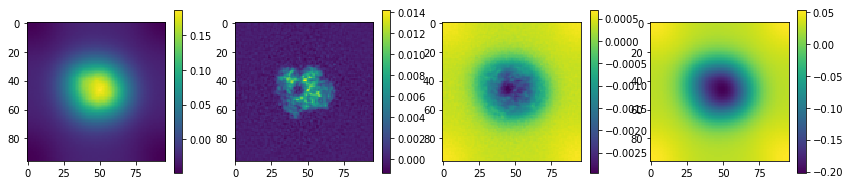

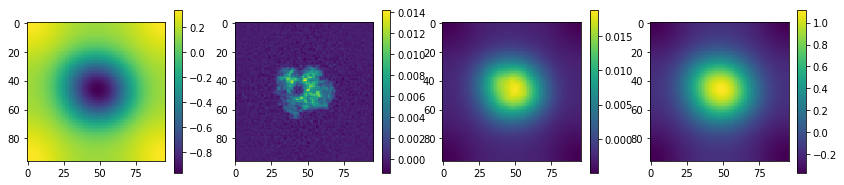

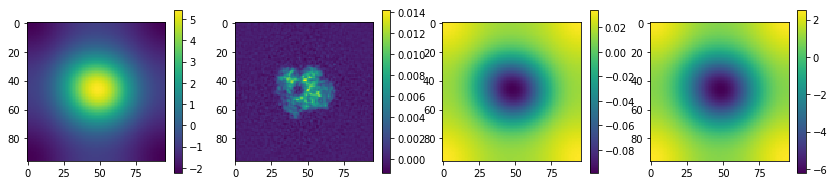

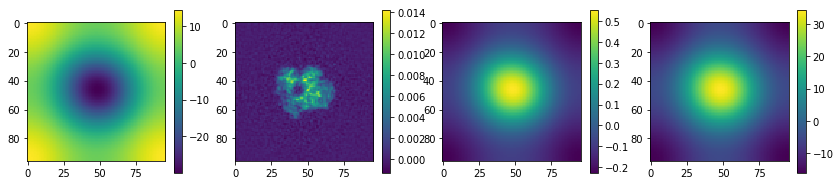

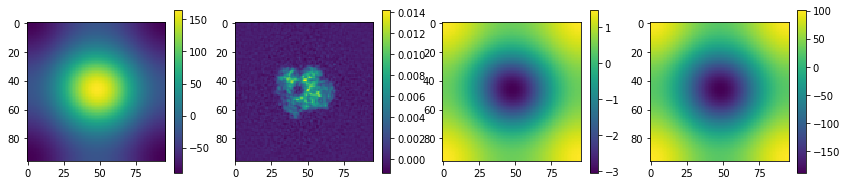

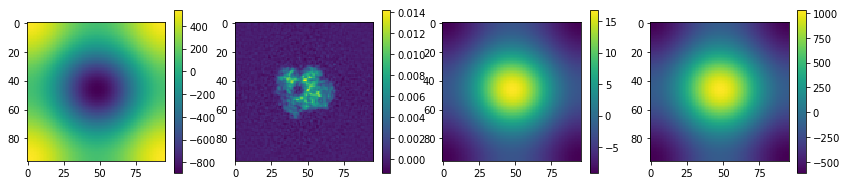

KeyboardInterrupt: 

In [13]:
REGULARIZATION_TY = 1e6

tikhonov_kernel = kernel + REGULARIZATION_TY
tikhonov = np.divide(complex_data, tikhonov_kernel)
reco = np.copy(tikhonov)

vis(reco)
plt.colorbar()
plt.show()

#print('reco', reco.shape)
def red_reg_grad(x):
#    print('x', x.shape)
#    print('den', denoiser.evaluate(x).shape)
    return x - denoiser.evaluate(x)

# The scales produce gradients of order 1
REG_SCALE = (96 ** (-0.5))
DATA_SCALE = 1 / (10 * 96 ** 3)
IMAGING_SCALE = 96
REG_PARAM = 1e0


for k in range(10):
    STEP_SIZE = 2.0 * 1 / np.sqrt(1 + k / 20)

    real_reco = unify_form(irfft(reco))
    g1 = REG_PARAM * REG_SCALE * rfft(red_reg_grad(real_reco).squeeze())
#    print('g1', g1.shape)
    g2 = DATA_SCALE * (np.multiply(reco, tikhonov_kernel) - complex_data)
#    print('g2', g2.shape)
    g = g1 + g2

    reco = reco - STEP_SIZE * g

    # Enforce positivy (makes things crash for some reason)
    #reco = np.fft.rfftn(np.maximum(0, np.fft.irfftn(reco)))
    
#    print('new reco', reco.shape)
    if k % 10 > -1:
        plt.figure(k, figsize=(18,3))
        plt.subplot(151)
        vis(reco)
        plt.colorbar()
        plt.subplot(152)
        vis(tikhonov)
        plt.colorbar()
        plt.subplot(153)
        vis(g1)
        plt.colorbar()
        plt.subplot(154)
        vis(STEP_SIZE* g2)
        plt.colorbar()
        plt.show()   
    

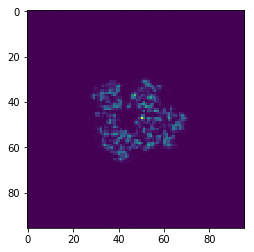

In [9]:
path_em = '/local/scratch/public/sl767/MRC_Data/Data/Data_002_10k/train/EM/3PNC/3PNC_mult002_class001.mrc'
with mrcfile.open(path_em) as mrc:
    em_final = mrc.data.copy()
em_final = em_final[None,...,None]
den = denoiser.evaluate(em_final)

def vis2(data):
    #plt.imshow(im[...,45])
#     plt.imshow(np.mean(data.squeeze(), axis=-1))
#     plt.imshow(data.squeeze().mean(axis=-1))
    plt.imshow(np.maximum(0,data.squeeze()[...,45]))

    
vis2(den)